Model loaded with labels: ['chew', 'chewbite', 'bite']
Analyzing recording: audios/recording_51.wav
Total recording duration: 121.71 seconds
Created 144 segments

=== COW CHEWING ANALYSIS REPORT ===

File: audios/recording_51.wav
Total Duration: 121.71 seconds (2.03 minutes)

=== EVENT SUMMARY ===
Pure Chew Events: 102
Chew-Bite Events: 11
Bite Events: 27
Total Chewing Duration (pure chew only): 89.85 seconds

=== CHEWING RATE ANALYSIS (Based on Pure Chew Events Only) ===
Chewing Rate: 68.11 chews per minute
Classification: HEALTHY

Timeline plot saved to: chewing_analysis_timeline.png


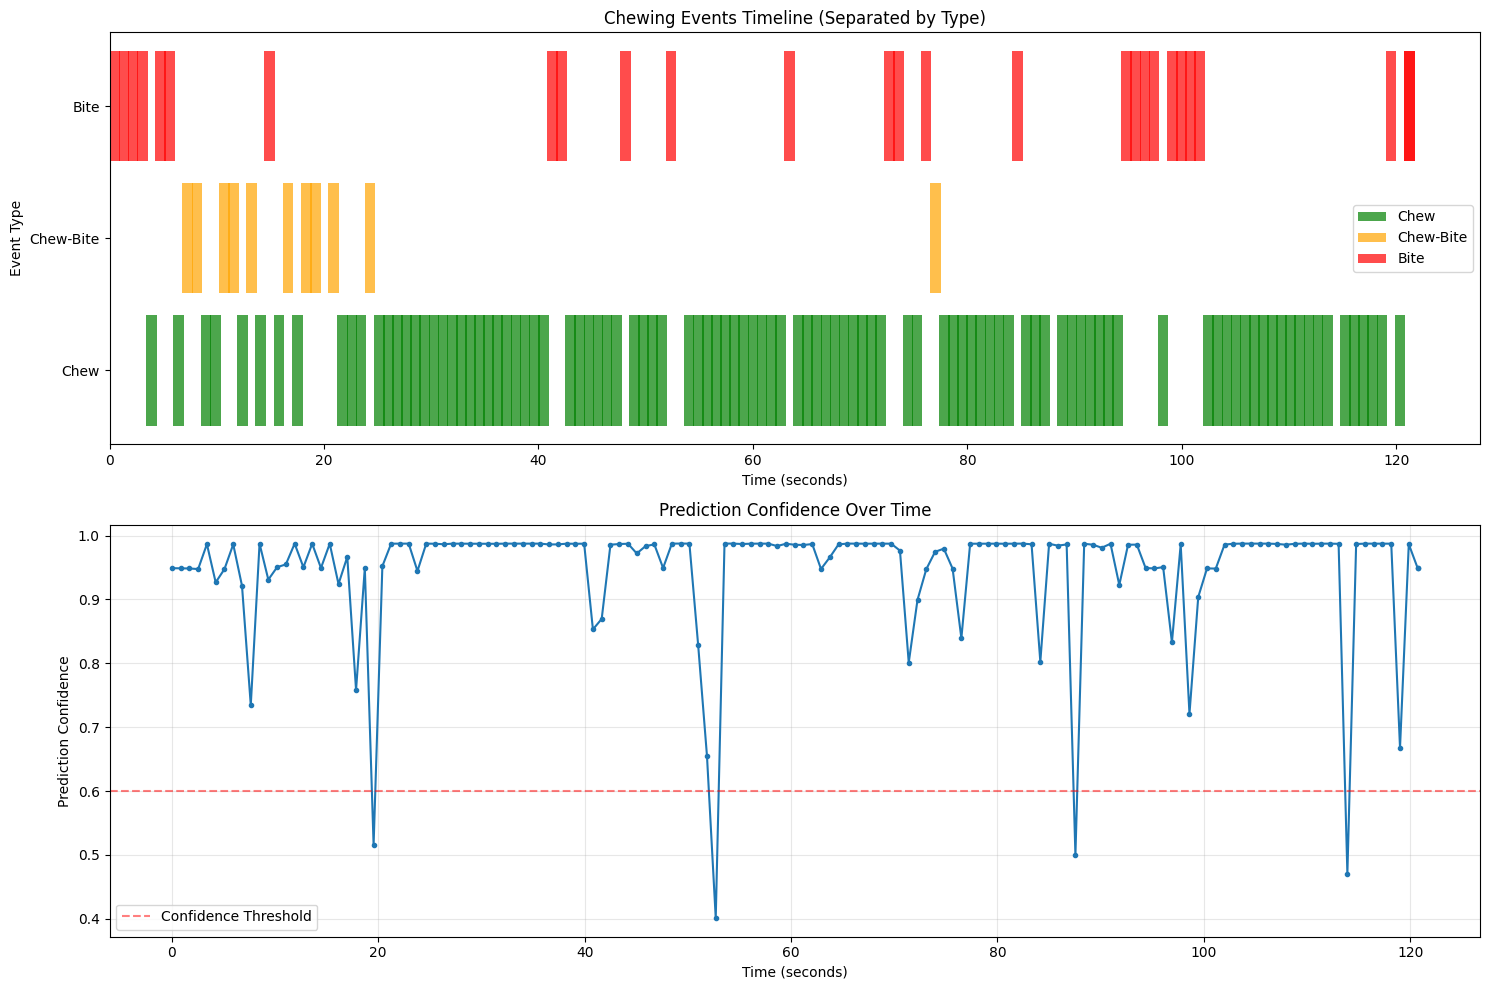

Detailed results saved to detailed_analysis.csv


In [14]:
import torch
import numpy as np
import librosa
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings("ignore")

class ChewingAnalyzer:
    def __init__(self, model_path: str, segment_duration: float = 1.0, overlap: float = 0.25):
        """
        Initialize the chewing analyzer
        
        Args:
            model_path: Path to the trained model
            segment_duration: Duration of each segment in seconds
            overlap: Overlap between segments (0.0 to 1.0)
        """
        self.model_path = model_path
        self.segment_duration = segment_duration
        self.overlap = overlap
        self.hop_duration = segment_duration * (1 - overlap)
        
        # Load model and processor
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
        self.model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
        self.model.eval()
        
        # Define correct label mappings (since model has numeric labels)
        self.id2label = {0: 'chew', 1: 'chewbite', 2: 'bite'}
        self.label2id = {'chew': 0, 'chewbite': 1, 'bite': 2}
        
        print(f"Model loaded with labels: {list(self.id2label.values())}")
        
        # Define event types - ONLY 'chew' events for chewing speed calculation
        self.chew_events = ['chew']  # Only pure chew events
        self.chewbite_events = ['chewbite']  # Separate category
        self.bite_events = ['bite']
        
    def load_audio(self, audio_path: str, target_sr: int = 16000) -> Tuple[np.ndarray, int]:
        """Load and resample audio file"""
        audio, sr = librosa.load(audio_path, sr=target_sr)
        return audio, sr
    
    def segment_audio(self, audio: np.ndarray, sr: int) -> List[Tuple[np.ndarray, float, float]]:
        """
        Segment audio into overlapping windows
        
        Returns:
            List of (audio_segment, start_time, end_time) tuples
        """
        segments = []
        segment_samples = int(self.segment_duration * sr)
        hop_samples = int(self.hop_duration * sr)
        
        for start_sample in range(0, len(audio) - segment_samples + 1, hop_samples):
            end_sample = start_sample + segment_samples
            segment = audio[start_sample:end_sample]
            start_time = start_sample / sr
            end_time = end_sample / sr
            segments.append((segment, start_time, end_time))
        
        # Handle the last segment if it doesn't fit perfectly
        if len(audio) % hop_samples != 0:
            start_sample = len(audio) - segment_samples
            if start_sample > 0:
                segment = audio[start_sample:]
                start_time = start_sample / sr
                end_time = len(audio) / sr
                segments.append((segment, start_time, end_time))
        
        return segments
    
    def predict_segment(self, audio_segment: np.ndarray, sr: int) -> Tuple[str, float]:
        """Predict the class of an audio segment"""
        # Preprocess audio
        inputs = self.processor(
            audio_segment,
            sampling_rate=sr,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=160000  # 10 seconds at 16kHz
        )
        
        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_id = torch.argmax(predictions, dim=-1).item()
            confidence = torch.max(predictions).item()
        
        predicted_label = self.id2label[predicted_id]
        return predicted_label, confidence
    
    def analyze_full_recording(self, audio_path: str, confidence_threshold: float = 0.6) -> Dict:
        """
        Analyze a full recording and extract chewing events
        
        Args:
            audio_path: Path to the audio file
            confidence_threshold: Minimum confidence for event detection
            
        Returns:
            Dictionary with analysis results
        """
        print(f"Analyzing recording: {audio_path}")
        
        # Load audio
        audio, sr = self.load_audio(audio_path)
        total_duration = len(audio) / sr
        print(f"Total recording duration: {total_duration:.2f} seconds")
        
        # Segment audio
        segments = self.segment_audio(audio, sr)
        print(f"Created {len(segments)} segments")
        
        # Analyze each segment
        results = []
        for i, (segment, start_time, end_time) in enumerate(segments):
            label, confidence = self.predict_segment(segment, sr)
            
            results.append({
                'segment_id': i,
                'start_time': start_time,
                'end_time': end_time,
                'duration': end_time - start_time,
                'predicted_label': label,
                'confidence': confidence,
                'is_chew': label in self.chew_events and confidence >= confidence_threshold,  # Only pure chew events
                'is_chewbite': label in self.chewbite_events and confidence >= confidence_threshold,  # Separate chewbite events
                'is_bite': label in self.bite_events and confidence >= confidence_threshold
            })
        
        # Convert to DataFrame for easier analysis
        df = pd.DataFrame(results)
        
        # Calculate statistics for each event type separately
        chew_segments = df[df['is_chew'] == True]  # Only pure chew events
        chewbite_segments = df[df['is_chewbite'] == True]  # Chewbite events
        bite_segments = df[df['is_bite'] == True]  # Bite events
        
        # Remove overlapping segments for accurate duration calculation
        unique_chew_segments = self._remove_overlapping_segments(chew_segments)
        
        # Merge consecutive chewing segments (only pure chew events)
        chewing_periods = self._merge_consecutive_events(unique_chew_segments)
        
        # Calculate metrics based ONLY on pure chew events
        total_chew_events = len(chew_segments)
        total_chewbite_events = len(chewbite_segments)
        total_bite_events = len(bite_segments)
        total_chewing_duration = sum([period['duration'] for period in chewing_periods])
        
        # Calculate chewing rate (ONLY pure chew events per minute)
        chewing_rate = (total_chew_events / total_chewing_duration) * 60 if total_chewing_duration > 0 else 0
        
        # Classify chewing speed based on pure chew events only
        chewing_classification = self._classify_chewing_speed(chewing_rate)
        
        analysis_results = {
            'total_duration': total_duration,
            'total_chew_events': total_chew_events,  # Only pure chew events
            'total_chewbite_events': total_chewbite_events,  # Separate chewbite count
            'total_bite_events': total_bite_events,
            'total_chewing_duration': total_chewing_duration,  # Duration of pure chew events
            'chewing_rate_per_minute': chewing_rate,  # Rate based on pure chew events only
            'chewing_classification': chewing_classification,
            'chewing_periods': chewing_periods,  # Periods of pure chew events
            'detailed_segments': df,
            'audio_path': audio_path
        }
        
        return analysis_results
    
    def _remove_overlapping_segments(self, segments_df: pd.DataFrame) -> pd.DataFrame:
        """Remove overlapping segments to get accurate duration calculation"""
        if segments_df.empty:
            return segments_df
        
        # Sort by start time
        sorted_segments = segments_df.sort_values('start_time').copy()
        unique_segments = []
        
        for _, segment in sorted_segments.iterrows():
            # Check if this segment overlaps significantly with any already added
            overlaps = False
            for existing in unique_segments:
                overlap_start = max(segment['start_time'], existing['start_time'])
                overlap_end = min(segment['end_time'], existing['end_time'])
                overlap_duration = max(0, overlap_end - overlap_start)
                
                # If overlap is more than 50% of either segment, skip this one
                if (overlap_duration > 0.5 * segment['duration'] or 
                    overlap_duration > 0.5 * existing['duration']):
                    overlaps = True
                    break
            
            if not overlaps:
                unique_segments.append(segment.to_dict())
        
        return pd.DataFrame(unique_segments) if unique_segments else pd.DataFrame()
    
    def _merge_consecutive_events(self, events_df: pd.DataFrame, max_gap: float = 0.5) -> List[Dict]:
        """Merge consecutive chewing events into periods"""
        if events_df.empty:
            return []
        
        events_sorted = events_df.sort_values('start_time')
        periods = []
        current_period = {
            'start_time': events_sorted.iloc[0]['start_time'],
            'end_time': events_sorted.iloc[0]['end_time'],
            'event_count': 1
        }
        
        for _, row in events_sorted.iloc[1:].iterrows():
            # If the gap between events is small, merge them
            if row['start_time'] - current_period['end_time'] <= max_gap:
                current_period['end_time'] = row['end_time']
                current_period['event_count'] += 1
            else:
                # Save current period and start new one
                current_period['duration'] = current_period['end_time'] - current_period['start_time']
                periods.append(current_period.copy())
                current_period = {
                    'start_time': row['start_time'],
                    'end_time': row['end_time'],
                    'event_count': 1
                }
        
        # Add the last period
        current_period['duration'] = current_period['end_time'] - current_period['start_time']
        periods.append(current_period)
        
        return periods
    
    def _classify_chewing_speed(self, chewing_rate: float) -> str:
        """
        Classify chewing speed based on rate
        
        Note: These thresholds should be adjusted based on veterinary research
        or your specific requirements
        """
        if chewing_rate < 45:  # Less than 45 chews per minute
            return "slow"
        elif chewing_rate > 84:  # More than 84 chews per minute
            return "fast"
        else:
            return "healthy"
    
    def generate_report(self, analysis_results: Dict) -> str:
        """Generate a detailed analysis report"""
        results = analysis_results
        
        report = f"""
=== COW CHEWING ANALYSIS REPORT ===

File: {results['audio_path']}
Total Duration: {results['total_duration']:.2f} seconds ({results['total_duration']/60:.2f} minutes)

=== EVENT SUMMARY ===
Pure Chew Events: {results['total_chew_events']}
Chew-Bite Events: {results['total_chewbite_events']}
Bite Events: {results['total_bite_events']}
Total Chewing Duration (pure chew only): {results['total_chewing_duration']:.2f} seconds

=== CHEWING RATE ANALYSIS (Based on Pure Chew Events Only) ===
Chewing Rate: {results['chewing_rate_per_minute']:.2f} chews per minute
Classification: {results['chewing_classification'].upper()}
"""
        
        return report
    
    def plot_timeline(self, analysis_results: Dict, save_path: str = None):
        """Plot a timeline visualization of the analysis"""
        df = analysis_results['detailed_segments']
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Plot 1: Event timeline with separate categories
        chew_segments = df[df['is_chew'] == True]
        chewbite_segments = df[df['is_chewbite'] == True]
        bite_segments = df[df['is_bite'] == True]
        
        # Create timeline with three separate categories
        for _, row in chew_segments.iterrows():
            ax1.barh(0, row['duration'], left=row['start_time'], height=0.25, 
                    color='green', alpha=0.7, label='Chew' if _ == chew_segments.index[0] else "")
        
        for _, row in chewbite_segments.iterrows():
            ax1.barh(0.3, row['duration'], left=row['start_time'], height=0.25, 
                    color='orange', alpha=0.7, label='Chew-Bite' if _ == chewbite_segments.index[0] else "")
        
        for _, row in bite_segments.iterrows():
            ax1.barh(0.6, row['duration'], left=row['start_time'], height=0.25, 
                    color='red', alpha=0.7, label='Bite' if _ == bite_segments.index[0] else "")
        
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Event Type')
        ax1.set_title('Chewing Events Timeline (Separated by Type)')
        ax1.legend()
        ax1.set_yticks([0, 0.3, 0.6])
        ax1.set_yticklabels(['Chew', 'Chew-Bite', 'Bite'])
        
        # Plot 2: Confidence scores over time
        ax2.plot(df['start_time'], df['confidence'], marker='o', markersize=3)
        ax2.axhline(y=0.6, color='r', linestyle='--', alpha=0.5, label='Confidence Threshold')
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Prediction Confidence')
        ax2.set_title('Prediction Confidence Over Time')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Timeline plot saved to: {save_path}")
        
        plt.show()

# Example usage
def main():
    # Initialize analyzer
    analyzer = ChewingAnalyzer(
        model_path="./final_cow_chewing_model",
        segment_duration=1.0,  # Reduced to 1-second segments for better detection
        overlap=0.15  
    )
    
    # Analyze a recording
    audio_file = "audios/recording_51.wav"  # Replace with your actual audio file path
    
    try:
        results = analyzer.analyze_full_recording(
            audio_file, 
            confidence_threshold=0.6
        )
        
        # Generate and print report
        report = analyzer.generate_report(results)
        print(report)
        
        # Plot timeline
        analyzer.plot_timeline(results, save_path="chewing_analysis_timeline.png")
        
        # Save detailed results to CSV
        results['detailed_segments'].to_csv("detailed_analysis.csv", index=False)
        print("Detailed results saved to detailed_analysis.csv")
        
        # Return key metrics (now based only on pure chew events)
        return {
            'chewing_rate': results['chewing_rate_per_minute'],
            'classification': results['chewing_classification'],
            'total_chew_events': results['total_chew_events'],
            'total_chewbite_events': results['total_chewbite_events'],
            'total_bite_events': results['total_bite_events'],
            'total_chewing_duration': results['total_chewing_duration']
        }
        
    except Exception as e:
        print(f"Error analyzing recording: {e}")
        return None

if __name__ == "__main__":
    main()